#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import matplotlib.pyplot as plt

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dsave\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dsave\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Предобработка

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

df = pd.read_csv("combined_data.csv")[0:25000]
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[{}0-9]+'.format(string.punctuation), ' ', text)
    tokens = word_tokenize(text)
    
    tokens = [word for word in tokens if word not in stop_words and word.strip() != '']
    text = ' '.join(tokens)
    return text

df['clean_text'] = df['text'].apply(preprocess_text)


## 2. Лемматизация

Лемматизация (Lemmatization) – это процесс приведения слов к их лемме, то есть к их канонической форме, учитывающей лексическое значение слова и его часть речи. Для этого используют словари.

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df['lemmatized_text'] = df['clean_text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dsave\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dsave\AppData\Roaming\nltk_data...


3. Разделение датасета на train и test выборки в отношении 4:1


In [7]:
from sklearn.model_selection import train_test_split

X = df['lemmatized_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Bag of words и TF-IDF.

- Bag of Words (BoW):
Метод "Мешок слов" строит вектор признаков, который отражает, какие слова (из всего словаря корпуса) и с какой частотой встречаются в тексте. При этом порядок слов не учитывается, а важность слова определяется простой частотой его появления.

- TF-IDF (Term Frequency – Inverse Document Frequency):
Метод TF-IDF также опирается на представление текста в виде набора слов, но при этом нормирует частоту слов по мере их встречаемости в других документах. Это помогает выделить более "информативные" термины и уменьшить вклад слишком распространённых, но малоинформативных слов.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)  
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

cv = StratifiedKFold(n_splits=3, shuffle=True)

# 1. Логистическая регрессия
lr = LogisticRegression(max_iter=1000)
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', None]
}
grid_lr = GridSearchCV(lr, param_grid_lr, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train_bow, y_train)

print("Лучшие параметры для Логистической регрессии:", grid_lr.best_params_)
print("Лучшее качество на кросс-валидации:", grid_lr.best_score_)
best_lr = grid_lr.best_estimator_

# 2. Случайный лес
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train_bow, y_train)

print("Лучшие параметры для Случайного леса:", grid_rf.best_params_)
print("Лучшее качество на кросс-валидации:", grid_rf.best_score_)
best_rf = grid_rf.best_estimator_

# 3. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.3, 0.5],
}
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_xgb.fit(X_train_bow, y_train)

print("Лучшие параметры для XGBoost:", grid_xgb.best_params_)
print("Лучшее качество на кросс-валидации:", grid_xgb.best_score_)
best_xgb = grid_xgb.best_estimator_


Лучшие параметры для Логистической регрессии: {'C': 1, 'penalty': 'l2'}
Лучшее качество на кросс-валидации: 0.9766792315739726
Лучшие параметры для Случайного леса: {'max_depth': None, 'n_estimators': 150}
Лучшее качество на кросс-валидации: 0.9721576181051783
Лучшие параметры для XGBoost: {'learning_rate': 0.3, 'n_estimators': 150}
Лучшее качество на кросс-валидации: 0.9746085279071686


6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Accuracy: 0.9814
Precision: 0.9726755218216319
Recall: 0.9918730650154799
F1-Score: 0.9821804943475761
ROC-AUC: 0.9938455318516392


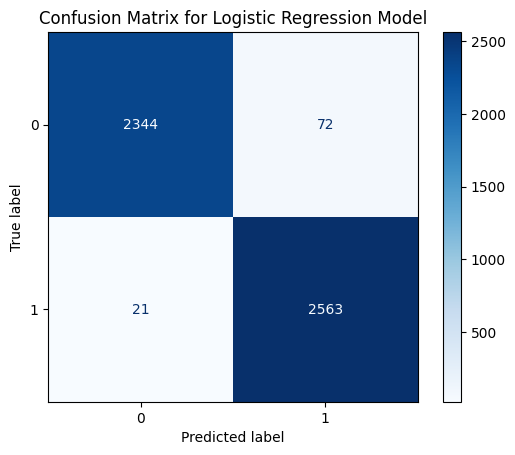

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = best_lr.predict(X_test_bow) 
y_proba = best_lr.predict_proba(X_test_bow)[:, 1]

# Рассчитаем метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')
rec = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)

# Строим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()

Accuracy: 0.9784
Precision: 0.9813374805598756
Recall: 0.9767801857585139
F1-Score: 0.9790535298681148
ROC-AUC: 0.9961392413579235


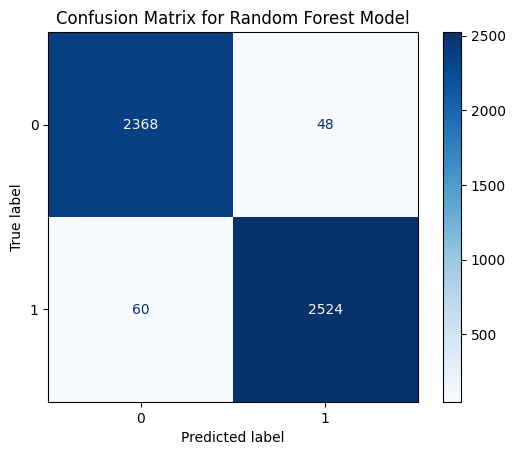

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = best_rf.predict(X_test_bow) 
y_proba = best_rf.predict_proba(X_test_bow)[:, 1]

# Рассчитаем метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')
rec = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)

# Строим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

Accuracy: 0.9816
Precision: 0.9726858877086495
Recall: 0.9922600619195047
F1-Score: 0.9823754789272031
ROC-AUC: 0.9977587497180817


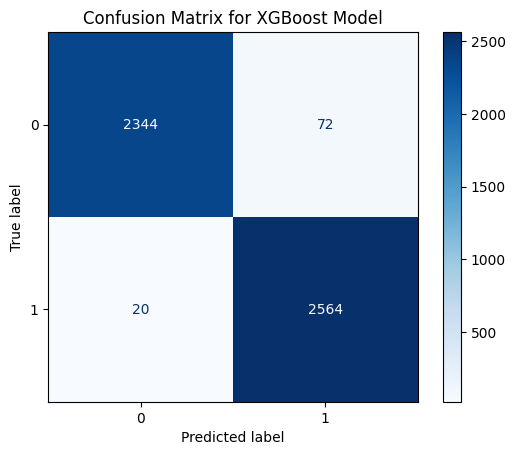

In [ ]:
y_pred = best_xgb.predict(X_test_bow) 
y_proba = best_xgb.predict_proba(X_test_bow)[:, 1]

# Рассчитаем метрики
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='binary')
rec = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)

# Строим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Model")
plt.show()

## Вывод
Все модели показали почти одинаковый результат

## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

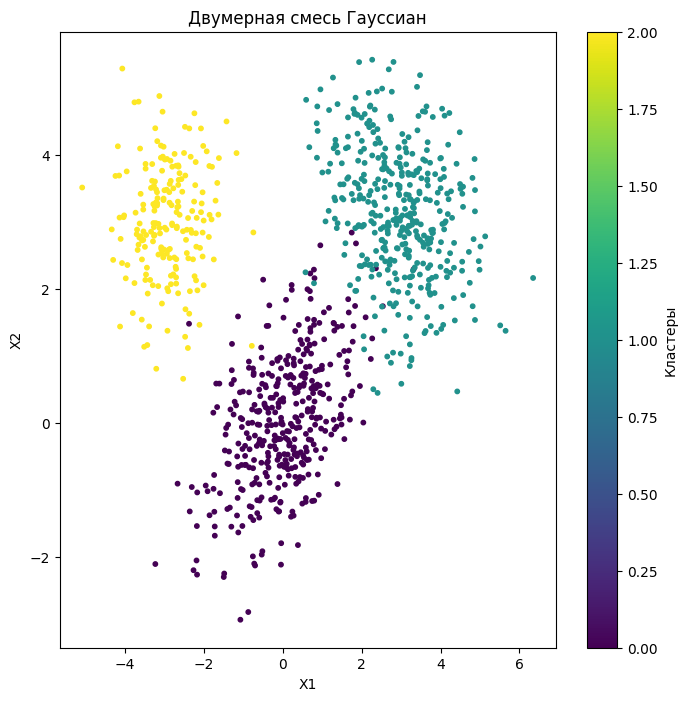

In [15]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

Лучшее количество кластеров: 3, сила метрики силуэта: 0.6064


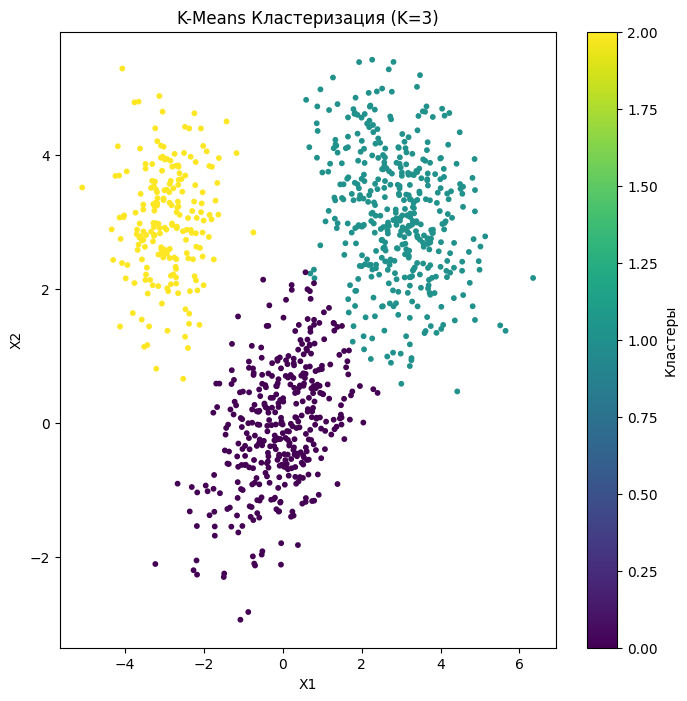

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = 2
best_score = 0

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Лучшее количество кластеров: {best_k}, сила метрики силуэта: {best_score:.4f}")

final_kmeans = KMeans(n_clusters=best_k, n_init=10)
final_labels = final_kmeans.fit_predict(X)

# Отрисовка кластеров
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='viridis', s=10)
plt.title(f"K-Means Кластеризация (K={best_k})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

Лучшие параметры: eps=0.5, min_samples=20
BCubed F1: 0.7872


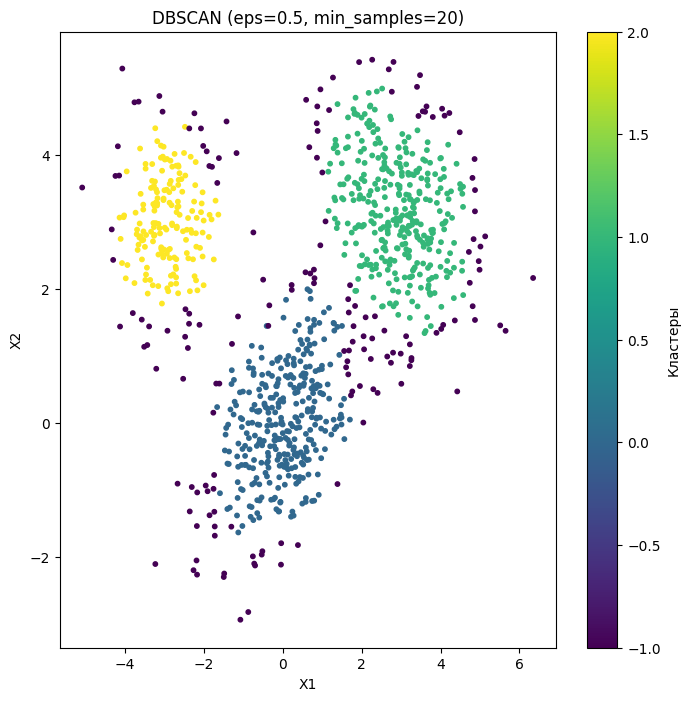

In [17]:
from sklearn.cluster import DBSCAN

def bcubed_precision_recall(true_labels, pred_labels):

    n = len(true_labels)
    precision_sum = 0.0
    recall_sum = 0.0

    pred_clusters = {}
    for i, c in enumerate(pred_labels):
        pred_clusters.setdefault(c, []).append(i)
        
    true_clusters = {}
    for i, c in enumerate(true_labels):
        true_clusters.setdefault(c, []).append(i)

    pred_clusters_sets = {c: set(indices) for c, indices in pred_clusters.items()}
    true_clusters_sets = {c: set(indices) for c, indices in true_clusters.items()}

    for i in range(n):
        pred_c = pred_labels[i]
        true_c = true_labels[i]
        
        pred_cluster = pred_clusters_sets[pred_c]
        true_cluster = true_clusters_sets[true_c]

        intersection_size = len(pred_cluster.intersection(true_cluster))

        precision_x = intersection_size / len(pred_cluster) if len(pred_cluster) > 0 else 0
        recall_x = intersection_size / len(true_cluster) if len(true_cluster) > 0 else 0
        
        precision_sum += precision_x
        recall_sum += recall_x

    precision = precision_sum / n
    recall = recall_sum / n
    return precision, recall


def bcubed_f1_score(true_labels, pred_labels):
    precision, recall = bcubed_precision_recall(true_labels, pred_labels)
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0.0
    return f1, precision, recall

eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [5, 10, 20]

best_f1 = -1
best_params = None
best_labels_pred = None

for eps in eps_values:
    for ms in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        pred = dbscan.fit_predict(X)
        f1, p, r = bcubed_f1_score(labels, pred)
        if f1 > best_f1:
            best_f1 = f1
            best_params = (eps, ms)
            best_labels_pred = pred

print(f"Лучшие параметры: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"BCubed F1: {best_f1:.4f}")

plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=best_labels_pred, cmap='viridis', s=10)
plt.title(f"DBSCAN (eps={best_params[0]}, min_samples={best_params[1]})")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

EM сошёлся на итерации 35
Сила метрики силуэта: 0.6025


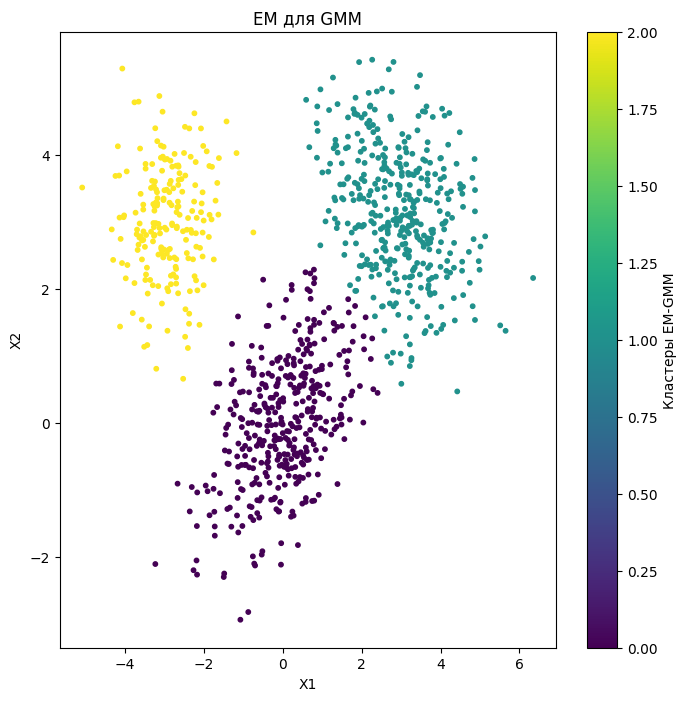

In [18]:
import numpy as np
import matplotlib.pyplot as plt

K = 3

n, d = X.shape

# Инициализируем средние как случайные точки из данных
mu = X[np.random.choice(n, K, replace=False)]
# Инициализируем каждую ковариационную матрицу как ковариацию выборки + регуляризация
Sigma = np.array([np.cov(X, rowvar=False) for _ in range(K)])
# Инициализируем веса равномерно
pi = np.ones(K) / K

# Вычисляем плотность многомерного Гауссиана для точки x.
def gaussian_pdf(x, mean, cov):
    size = len(x)
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    norm_const = 1.0 / ((2 * np.pi) ** (size / 2) * (det_cov ** 0.5))
    diff = (x - mean)
    return norm_const * np.exp(-0.5 * diff.T @ inv_cov @ diff)

max_iter = 100
tol = 1e-6
log_likelihoods = []

for iteration in range(max_iter):
    # E-step:
    # Для каждого i и k вычисляем p(z_ik=1|x_i) = g_ik
    # 1. Считаем весовую плотность pi_k * N(x_i|mu_k, Sigma_k)
    gammas = np.zeros((n, K))
    for i in range(n):
        for k in range(K):
            gammas[i, k] = pi[k] * gaussian_pdf(X[i], mu[k], Sigma[k])
    # 2. Нормируем по k, чтобы сумма по k была 1
    gammas = gammas / gammas.sum(axis=1, keepdims=True)

    # M-step:
    # Пересчитываем pi_k, mu_k, Sigma_k
    Nk = gammas.sum(axis=0)  # сумма по всем i для каждой компоненты k
    pi = Nk / n

    for k in range(K):
        # mu_k
        mu[k] = np.sum(gammas[:, k].reshape(-1, 1) * X, axis=0) / Nk[k]
        # Sigma_k
        diff = X - mu[k]
        Sigma[k] = (diff.T @ (diff * gammas[:, k].reshape(-1, 1))) / Nk[k]

    # Проверим сходимость по log-правдоподобию
    log_likelihood = 0.0
    for i in range(n):
        tmp = 0.0
        for k in range(K):
            tmp += pi[k] * gaussian_pdf(X[i], mu[k], Sigma[k])
        log_likelihood += np.log(tmp + 1e-12)
    log_likelihoods.append(log_likelihood)

    if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
        print(f"EM сошёлся на итерации {iteration}")
        break

# После сходимости или прохождения max_iter определяем кластеры
cluster_assignments = np.argmax(gammas, axis=1)

score = silhouette_score(X, cluster_assignments)
print(f"Сила метрики силуэта: {score:.4f}")

plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=cluster_assignments, cmap='viridis', s=10)
plt.title("EM для GMM")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры EM-GMM")
plt.show()

# Отчёт
На сгенерированных данных метод **K_mean** и **EM алгоритм** показали себя одинаково хорошо.

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

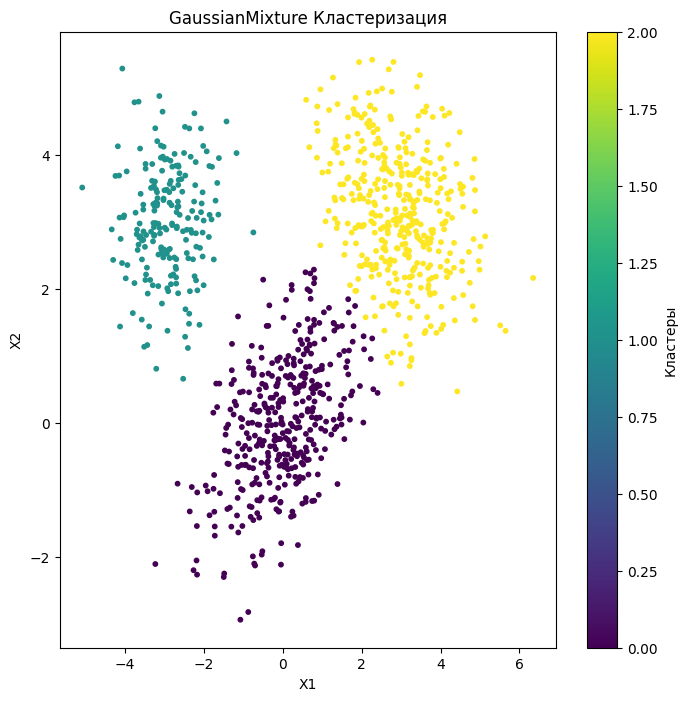

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

K = 3

gm = GaussianMixture(n_components=K, covariance_type='full', random_state=42)
gm.fit(X)
pred_labels = gm.predict(X)

# Визуализация результатов
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=pred_labels, cmap='viridis', s=10)
plt.title("GaussianMixture Кластеризация")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()
